C:\Users\codek\AppData\Local\Temp\ipykernel_13136\2750392106.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ttl_df.index,rotation=90)
C:\Users\codek\AppData\Local\Temp\ipykernel_13136\2750392106.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ttl_df.index,rotation=90)


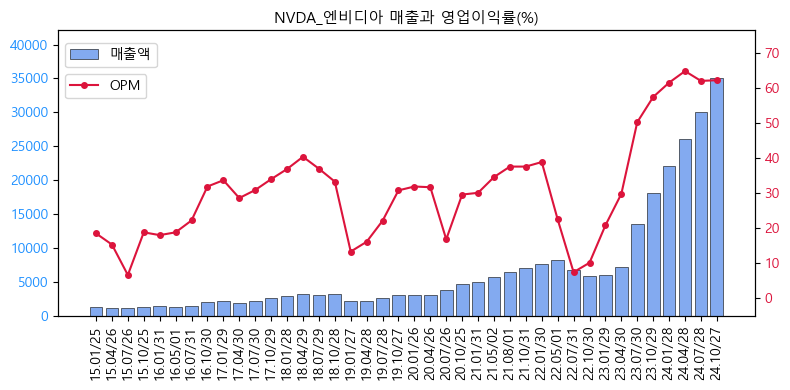

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
from datetime import datetime
import FinanceDataReader as fdr


today = datetime.today().strftime('%Y%m%d')



def sp500_finance(ticker):
    url = f'https://www.choicestock.co.kr/search/financials/{ticker}/MRQ'
    res = requests.get(url)
    soup = BeautifulSoup(res.text,'html.parser')

    # dd = soup.find('div',{'class':'scroll_table'})

    head = soup.find('thead') 
    trs = head.find_all('tr')

    trs_list = []
    for tr in trs:

        trr = tr.text
        # trr = trr.strip()
        trr = trr.split('\n')

        trs_list.append(trr)
    body = soup.find('tbody') 
    items = body.find_all('tr',{'class':'tr_emphasis'})

    info_list = []
    for item in items:

        information= item.text
        # information = information.strip()
        info = information.split('\n')
        info_list.append(info)

    df = pd.DataFrame(info_list,columns=trs_list[0])
    df = df.loc[:, df.columns != '']
    df.insert(0,'sort',['매출액','영업이익','순이익'])
    df = df.set_index('sort')
    df = df.apply(lambda x : x.str.replace(',',''))
    df = df.apply(pd.to_numeric,errors='ignore')
    df = df.T
    df.sort_index(ascending=True, inplace=True)
    df['매출성장률'] = round(df['매출액'].pct_change(4) *100,0)
    df['영익성장률'] = df['영업이익'].diff(4) / abs(df['영업이익'].shift(4)) * 100
    df['영익성장률'] = round(df['영익성장률'], 0)
    df['OPM'] = round((df['영업이익']/df['매출액'])*100,1)
    df['NPM'] = round((df['순이익']/df['매출액'])*100,1)
    return df

def sp500_graph(ttl_df,symbor,name):
    
    font_path='./malgun.ttf'
    font_name=font_manager.FontProperties(fname=font_path).get_name()
    rc('font',family=font_name)
    plt.rc('axes',unicode_minus=False)

    # 그래프 사이즈를 키우기 위해 figsize 파라미터를 추가합니다.
    fig, ax1 = plt.subplots(figsize=(8, 4))

    ax1.set_title(f'{symbor}_{name} 매출과 영업이익률(%)',size=11)

    ax1.bar(ttl_df.index, ttl_df['매출액'], color='cornflowerblue',alpha=0.8,label='매출액',edgecolor='black',linewidth = 0.5)
    ax1.tick_params(axis='y', labelcolor='dodgerblue')
    ax1.margins(y=0.2)
    # 오른쪽 축을 추가합니다.
    ax2 = ax1.twinx()
    ax2.plot(ttl_df.index, ttl_df['OPM'], marker='o', markersize=4,color='crimson',label='OPM')
    ax2.tick_params(axis='y', labelcolor='crimson')
    ax2.margins(y=0.2)

    ax1.set_xticklabels(ttl_df.index,rotation=90)
    ax2.set_xticklabels(ttl_df.index,rotation=90)
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.98))
    ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.87))

    fig.tight_layout()
    plt.savefig(f'./graph/{symbor}_{name}_{today}.jpg', format='jpg', dpi=300)
    plt.show()
    return

symbor = 'NVDA'
name = '엔비디아'

df = sp500_finance(symbor)
sp500_graph(df,symbor,name)


df.to_excel(f'./america_finance/{symbor}_{name}_{today}.xlsx')